In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pptx import Presentation
from pptx.util import Inches, Pt

plt.style.use("ggplot")
sns.set(style="whitegrid")

FIG_DIR = "figures"
today = datetime.now().strftime("%Y-%m-%d")
PPTX_PATH = f"Tech_Workforce_Visualization_{today}.pptx"

os.makedirs(FIG_DIR, exist_ok=True)



In [6]:
# Loading datasets
layoffs = pd.read_csv("layoffs.csv")
jobs = pd.read_csv("jobs_in_data.csv")

# Preprocessing layoffs data
layoffs["date"] = pd.to_datetime(layoffs["date"], errors="coerce")
layoffs["year"] = layoffs["date"].dt.year
layoffs["month"] = layoffs["date"].dt.month
layoffs["year_month"] = layoffs["date"].dt.to_period("M").astype(str)
layoffs = layoffs.sort_values("date")

# Preprocessing jobs data
jobs["work_year"] = jobs["work_year"].astype(int)
jobs["salary_in_usd"] = jobs["salary_in_usd"].astype(float)
jobs = jobs.dropna(subset=["salary_in_usd"]).copy()
jobs["job_category_clean"] = jobs["job_category"].str.strip()
jobs["experience_level_clean"] = jobs["experience_level"].str.strip()
jobs["work_setting_clean"] = jobs["work_setting"].str.strip()
jobs["company_size_clean"] = jobs["company_size"].str.strip()

# ----- FIGURE GENERATION HELPERS -----
def save_current_fig(filename):
    path = os.path.join(FIG_DIR, filename)
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")
    plt.close()
    return path

figure_paths = {}


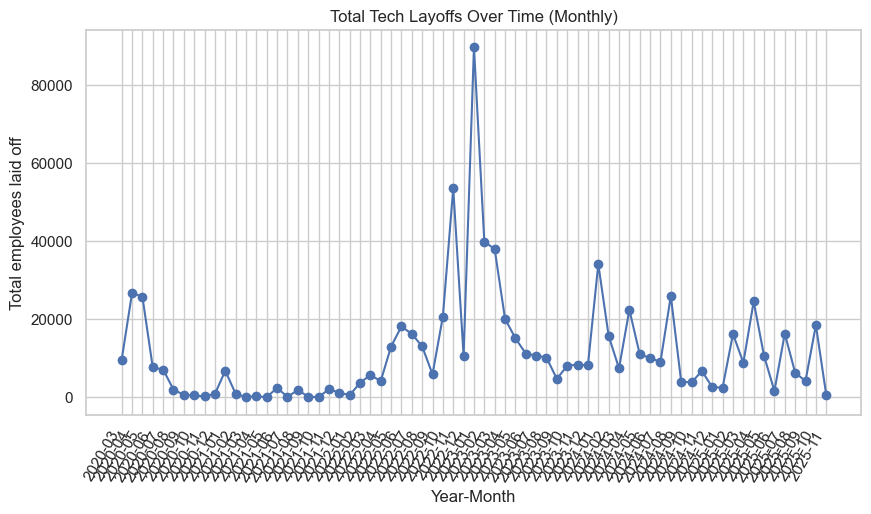

In [7]:

# ======================
# LAYOFFS VISUALIZATIONS
# ======================

# 1. Total layoffs over time by month
monthly_layoffs = (
    layoffs.groupby("year_month")["total_laid_off"]
    .sum()
    .reset_index()
    .dropna()
)

plt.figure(figsize=(10, 5))
plt.plot(monthly_layoffs["year_month"], monthly_layoffs["total_laid_off"], marker="o")
plt.xticks(rotation=60, ha="right")
plt.xlabel("Year-Month")
plt.ylabel("Total employees laid off")
plt.title("Total Tech Layoffs Over Time (Monthly)")
plt.show()
figure_paths["layoffs_monthly"] = save_current_fig("layoffs_monthly.png")


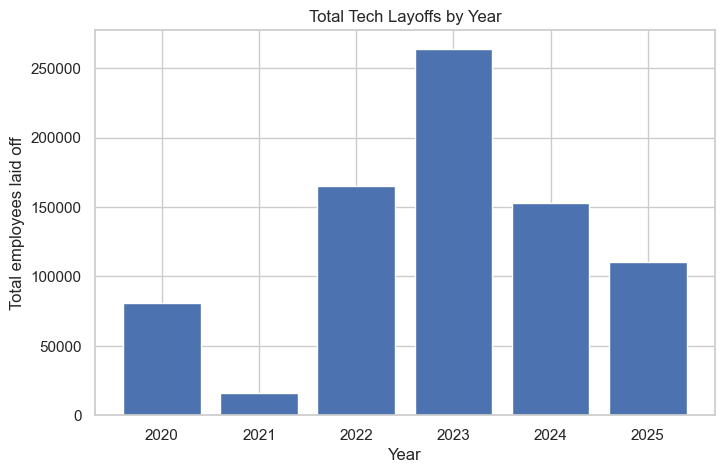

In [8]:

# 2. Total layoffs by year
yearly_layoffs = (
    layoffs.groupby("year")["total_laid_off"]
    .sum()
    .reset_index()
    .dropna()
)

plt.figure(figsize=(8, 5))
plt.bar(yearly_layoffs["year"].astype(str), yearly_layoffs["total_laid_off"])
plt.xlabel("Year")
plt.ylabel("Total employees laid off")
plt.title("Total Tech Layoffs by Year")
plt.show()
figure_paths["layoffs_yearly"] = save_current_fig("layoffs_yearly.png")


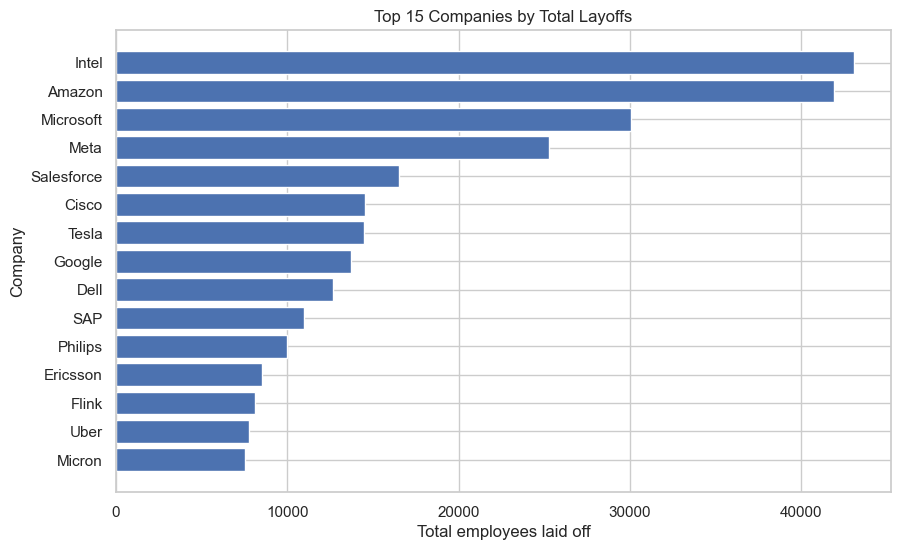

In [9]:

# 3. Top 15 companies by total layoffs
company_layoffs = (
    layoffs.groupby("company")["total_laid_off"]
    .sum()
    .reset_index()
    .dropna()
    .sort_values("total_laid_off", ascending=False)
    .head(15)
)

plt.figure(figsize=(10, 6))
plt.barh(company_layoffs["company"][::-1], company_layoffs["total_laid_off"][::-1])
plt.xlabel("Total employees laid off")
plt.ylabel("Company")
plt.title("Top 15 Companies by Total Layoffs")
plt.show()
figure_paths["layoffs_top_companies"] = save_current_fig("layoffs_top_companies.png")


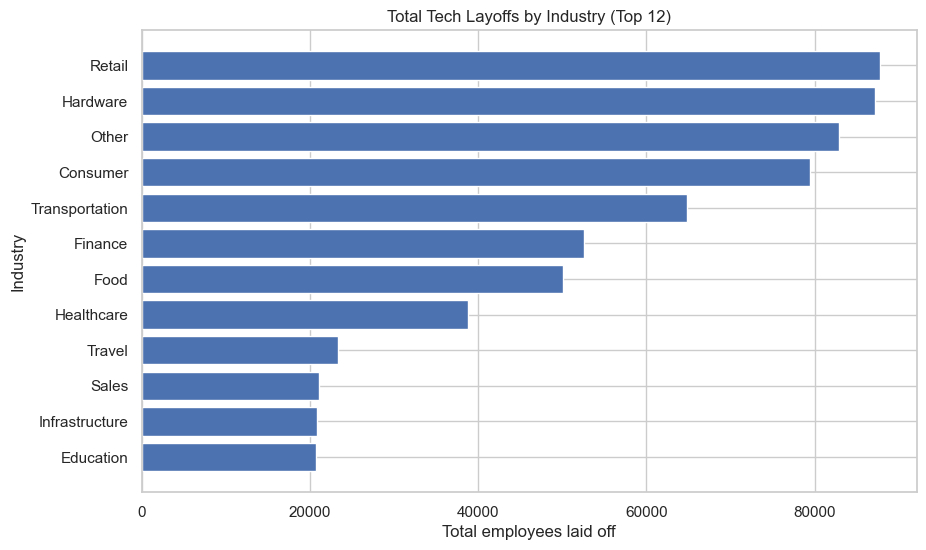

In [10]:

# 4. Total layoffs by industry (top 12)
industry_layoffs = (
    layoffs.groupby("industry")["total_laid_off"]
    .sum()
    .reset_index()
    .dropna()
    .sort_values("total_laid_off", ascending=False)
)

top_industries = industry_layoffs.head(12)

plt.figure(figsize=(10, 6))
plt.barh(top_industries["industry"][::-1], top_industries["total_laid_off"][::-1])
plt.xlabel("Total employees laid off")
plt.ylabel("Industry")
plt.title("Total Tech Layoffs by Industry (Top 12)")
plt.show()
figure_paths["layoffs_industry"] = save_current_fig("layoffs_industry.png")


/var/folders/40/sdhd020s23j5xmv9v34h73pm0000gn/T/ipykernel_77382/675903690.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_industry_names, showfliers=False)


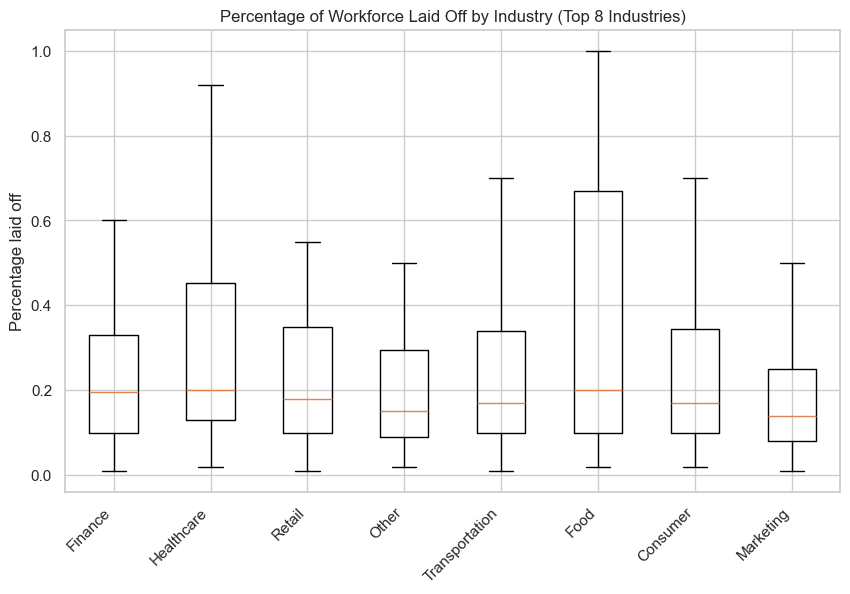

In [11]:

# 5. Percentage laid off by industry (boxplot for top 8 industries)
perc_df = layoffs[["industry", "percentage_laid_off"]].dropna()
top_industry_names = (
    perc_df["industry"].value_counts().head(8).index.tolist()
)
perc_df = perc_df[perc_df["industry"].isin(top_industry_names)]

plt.figure(figsize=(10, 6))
data = [perc_df[perc_df["industry"] == ind]["percentage_laid_off"] for ind in top_industry_names]
plt.boxplot(data, labels=top_industry_names, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Percentage laid off")
plt.title("Percentage of Workforce Laid Off by Industry (Top 8 Industries)")
plt.show()
figure_paths["layoffs_percentage_industry"] = save_current_fig("layoffs_percentage_industry.png")


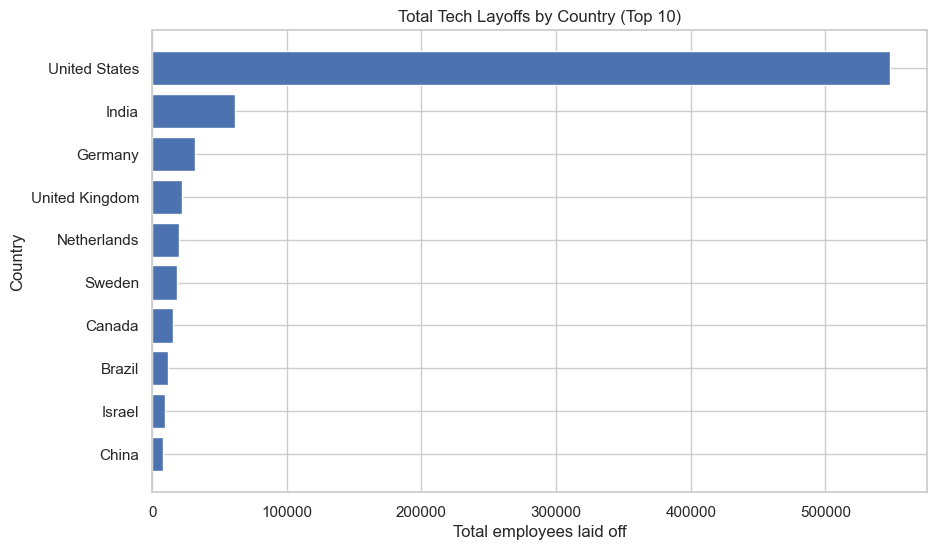

In [12]:

# 6. Total layoffs by country (top 10)
country_layoffs = (
    layoffs.groupby("country")["total_laid_off"]
    .sum()
    .reset_index()
    .dropna()
    .sort_values("total_laid_off", ascending=False)
)

top_countries_layoffs = country_layoffs.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_countries_layoffs["country"][::-1], top_countries_layoffs["total_laid_off"][::-1])
plt.xlabel("Total employees laid off")
plt.ylabel("Country")
plt.title("Total Tech Layoffs by Country (Top 10)")
plt.show()
figure_paths["layoffs_country"] = save_current_fig("layoffs_country.png")


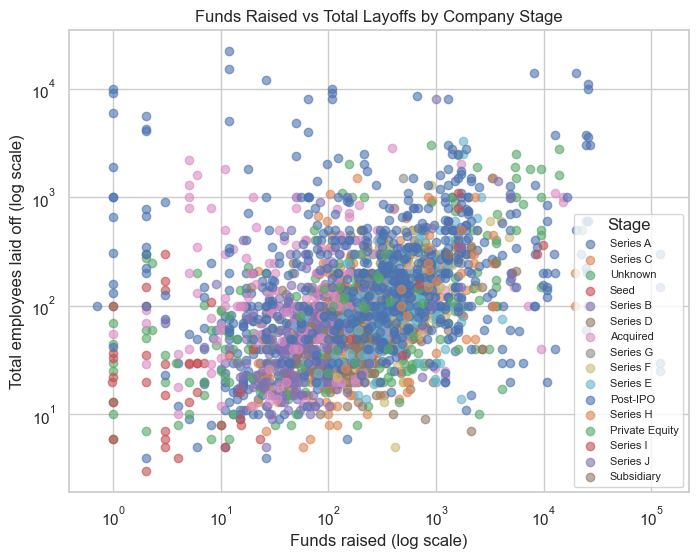

In [13]:

# 7. Funds raised vs total layoffs (log-log scatter, colored by stage)
scatter_df = layoffs[["funds_raised", "total_laid_off", "stage"]].dropna()

plt.figure(figsize=(8, 6))
stages = scatter_df["stage"].unique()
for stage in stages:
    subset = scatter_df[scatter_df["stage"] == stage]
    plt.scatter(
        subset["funds_raised"],
        subset["total_laid_off"],
        alpha=0.6,
        label=stage
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Funds raised (log scale)")
plt.ylabel("Total employees laid off (log scale)")
plt.title("Funds Raised vs Total Layoffs by Company Stage")
plt.legend(title="Stage", fontsize=8)
plt.show()
figure_paths["layoffs_funds_scatter"] = save_current_fig("layoffs_funds_scatter.png")


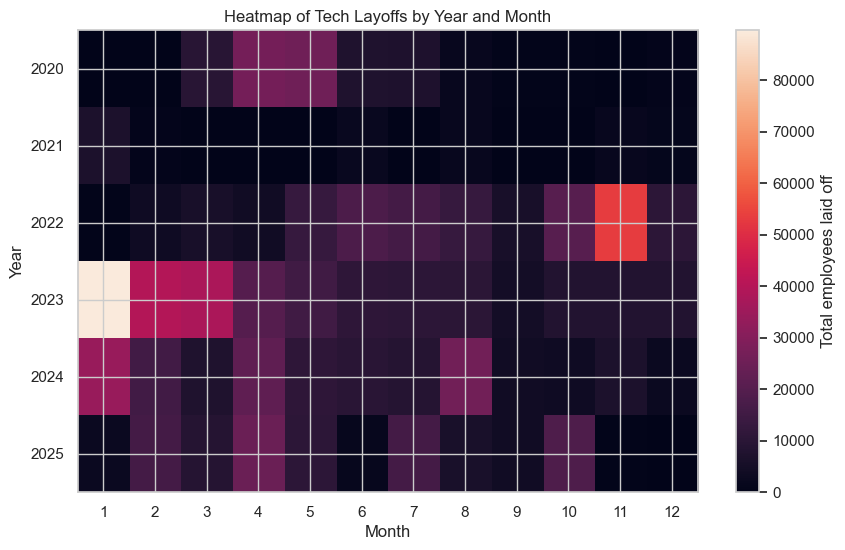

In [24]:

# 8. Heatmap of layoffs by year and month
heat_df = layoffs.dropna(subset=["year", "month", "total_laid_off"])

pivot = heat_df.pivot_table(
    index="year",
    columns="month",
    values="total_laid_off",
    aggfunc="sum"
).fillna(0)

plt.figure(figsize=(10, 6))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Total employees laid off")
plt.xticks(ticks=np.arange(0, 12), labels=range(1, 13))
plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
plt.xlabel("Month")
plt.ylabel("Year")
plt.title("Heatmap of Tech Layoffs by Year and Month")
plt.show()
figure_paths["layoffs_heatmap_time"] = save_current_fig("layoffs_heatmap_time.png")


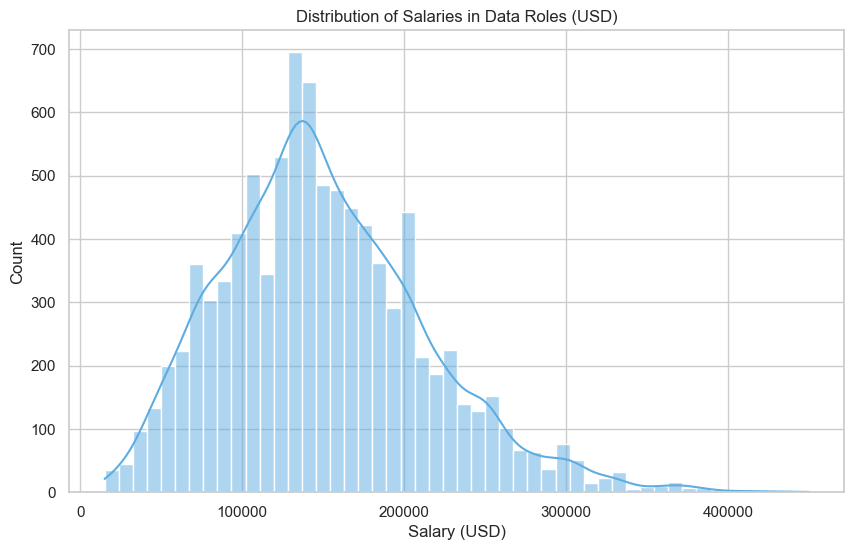

In [15]:

# ====================
# JOBS VISUALIZATIONS
# ====================

# 1. Distribution of salaries
plt.figure(figsize=(10, 6))
sns.histplot(jobs["salary_in_usd"], bins=50, kde=True, color="#5DADE2")
plt.xlabel("Salary (USD)")
plt.ylabel("Count")
plt.title("Distribution of Salaries in Data Roles (USD)")
plt.show()
figure_paths["jobs_salary_distribution"] = save_current_fig("jobs_salary_distribution.png")


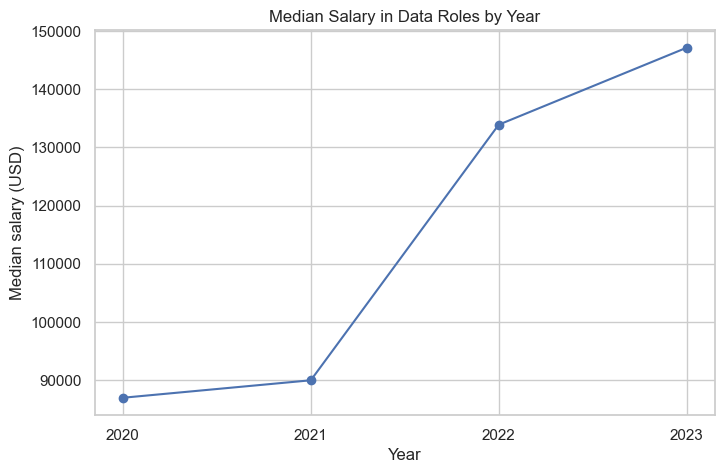

In [16]:

# 2. Median salary by year
yearly_salary = (
    jobs.groupby("work_year")["salary_in_usd"]
    .median()
    .reset_index()
)

plt.figure(figsize=(8, 5))
plt.plot(yearly_salary["work_year"], yearly_salary["salary_in_usd"], marker="o")
plt.xlabel("Year")
plt.ylabel("Median salary (USD)")
plt.title("Median Salary in Data Roles by Year")
plt.xticks(yearly_salary["work_year"])
plt.show()
figure_paths["jobs_salary_by_year"] = save_current_fig("jobs_salary_by_year.png")


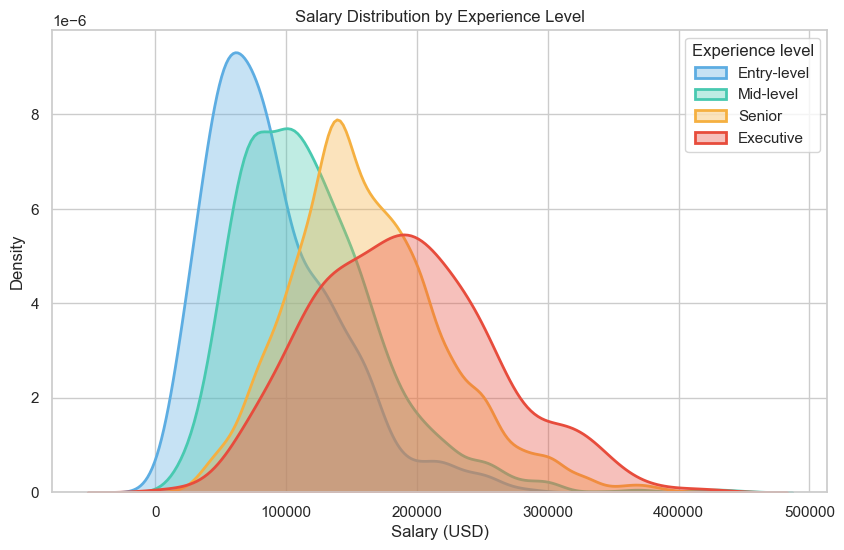

In [17]:

# 3. Salary distribution by experience level (mountain chart)
exp_order = ["Entry-level", "Mid-level", "Senior", "Executive"]
jobs["experience_level_clean"] = pd.Categorical(
    jobs["experience_level_clean"],
    categories=exp_order,
    ordered=True
)

plt.figure(figsize=(10, 6))
colors = ["#5DADE2", "#48C9B0", "#F5B041", "#E74C3C"]

for i, level in enumerate(exp_order):
    subset = jobs[jobs["experience_level_clean"] == level]
    if subset.empty:
        continue
    sns.kdeplot(
        data=subset,
        x="salary_in_usd",
        fill=True,
        alpha=0.35,
        linewidth=2,
        color=colors[i],
        label=level
    )

plt.xlabel("Salary (USD)")
plt.ylabel("Density")
plt.title("Salary Distribution by Experience Level")
plt.legend(title="Experience level")
plt.show()
figure_paths["jobs_salary_by_experience"] = save_current_fig("jobs_salary_by_experience.png")


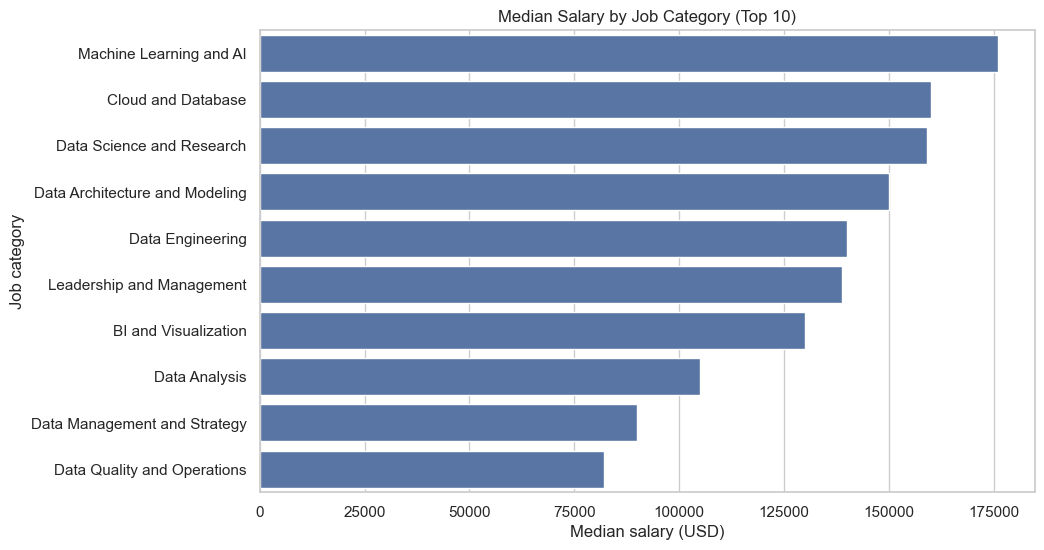

In [18]:

# 4. Median salary by job category (top 10)
category_counts = jobs["job_category_clean"].value_counts()
top_categories = category_counts.head(10).index.tolist()
cat_df = jobs[jobs["job_category_clean"].isin(top_categories)]

median_salary_by_category = (
    cat_df.groupby("job_category_clean")["salary_in_usd"]
    .median()
    .reset_index()
    .sort_values("salary_in_usd", ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=median_salary_by_category,
    x="salary_in_usd",
    y="job_category_clean",
    orient="h"
)
plt.xlabel("Median salary (USD)")
plt.ylabel("Job category")
plt.title("Median Salary by Job Category (Top 10)")
plt.show()
figure_paths["jobs_salary_by_category"] = save_current_fig("jobs_salary_by_category.png")


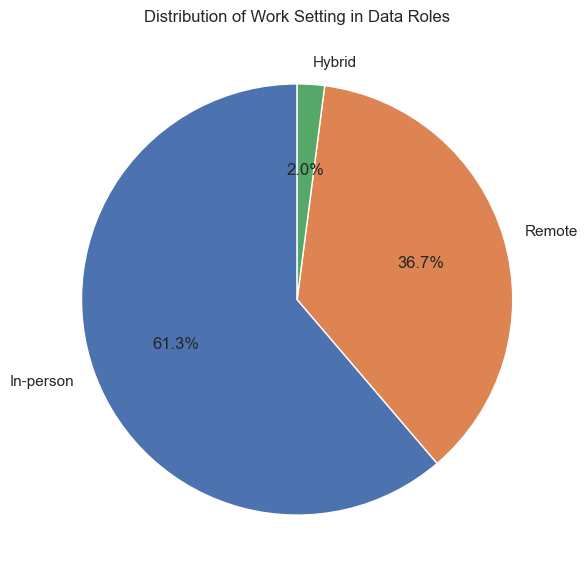

In [19]:

# 5. Work setting distribution (pie chart)
setting_counts = jobs["work_setting_clean"].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(
    setting_counts.values,
    labels=setting_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Distribution of Work Setting in Data Roles")
plt.show()
figure_paths["jobs_work_setting_pie"] = save_current_fig("jobs_work_setting_pie.png")


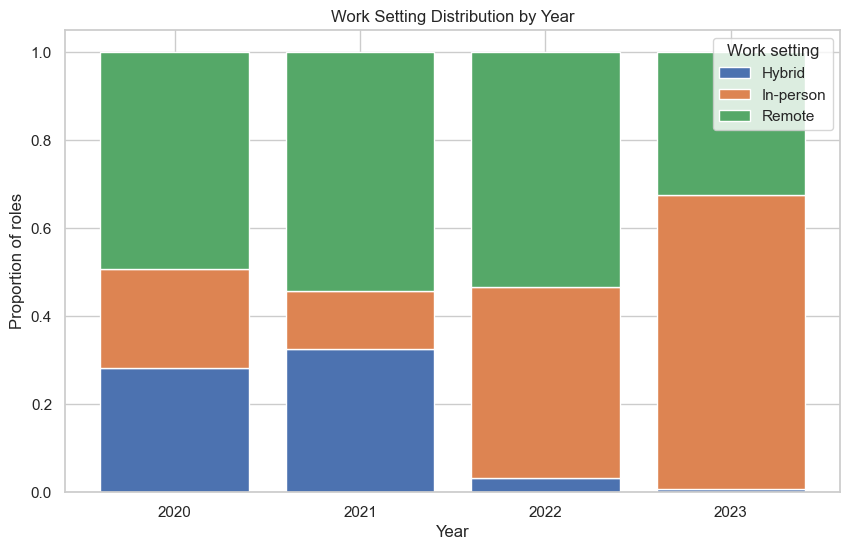

In [20]:

# 6. Work setting distribution by year (stacked bar, proportions)
setting_year = (
    jobs.groupby(["work_year", "work_setting_clean"])
    .size()
    .reset_index(name="count")
)

pivot_setting_year = setting_year.pivot(
    index="work_year",
    columns="work_setting_clean",
    values="count"
).fillna(0)

pivot_setting_year_norm = pivot_setting_year.div(pivot_setting_year.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
bottom = np.zeros(len(pivot_setting_year_norm))

for setting in pivot_setting_year_norm.columns:
    values = pivot_setting_year_norm[setting].values
    plt.bar(
        pivot_setting_year_norm.index.astype(str),
        values,
        bottom=bottom,
        label=setting
    )
    bottom += values

plt.xlabel("Year")
plt.ylabel("Proportion of roles")
plt.title("Work Setting Distribution by Year")
plt.legend(title="Work setting")
plt.show()
figure_paths["jobs_work_setting_by_year"] = save_current_fig("jobs_work_setting_by_year.png")


/var/folders/40/sdhd020s23j5xmv9v34h73pm0000gn/T/ipykernel_77382/1823653906.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  jobs.groupby(["work_year", "experience_level_clean"])["salary_in_usd"]


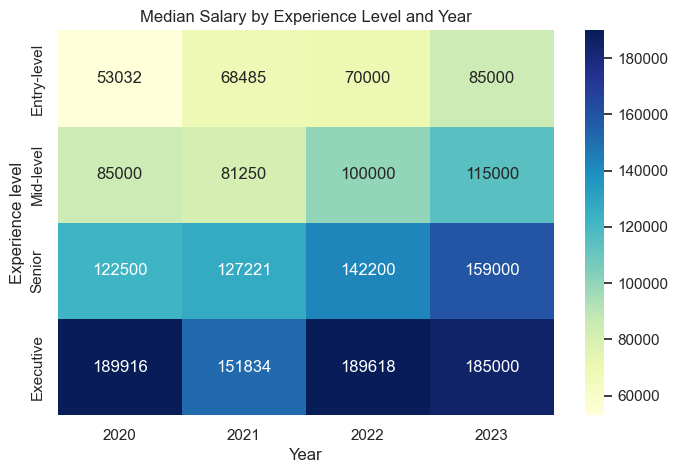

In [21]:

# 7. Median salary by experience level and year (heatmap)
heat_df_jobs = (
    jobs.groupby(["work_year", "experience_level_clean"])["salary_in_usd"]
    .median()
    .reset_index()
    .dropna(subset=["experience_level_clean"])
)

pivot_heat = heat_df_jobs.pivot(
    index="experience_level_clean",
    columns="work_year",
    values="salary_in_usd"
)

plt.figure(figsize=(8, 5))
sns.heatmap(
    pivot_heat,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu"
)
plt.xlabel("Year")
plt.ylabel("Experience level")
plt.title("Median Salary by Experience Level and Year")
plt.show()
figure_paths["jobs_salary_heatmap"] = save_current_fig("jobs_salary_heatmap.png")


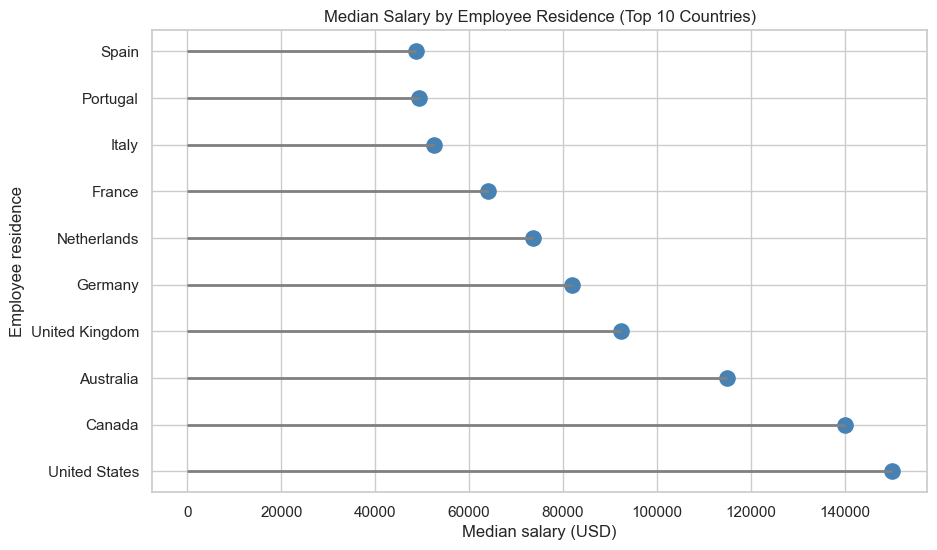

In [22]:

# 8. Median salary by employee residence (top 10, lollipop)
country_counts_jobs = jobs["employee_residence"].value_counts()
top_countries_jobs = country_counts_jobs.head(10).index.tolist()
country_df_jobs = jobs[jobs["employee_residence"].isin(top_countries_jobs)]

median_salary_by_country = (
    country_df_jobs.groupby("employee_residence")["salary_in_usd"]
    .median()
    .reset_index()
    .sort_values("salary_in_usd", ascending=False)
)

plt.figure(figsize=(10, 6))
y = median_salary_by_country["employee_residence"]
x = median_salary_by_country["salary_in_usd"]
plt.hlines(y=y, xmin=0, xmax=x, color="gray", linewidth=2)
plt.scatter(x, y, color="steelblue", s=120)
plt.xlabel("Median salary (USD)")
plt.ylabel("Employee residence")
plt.title("Median Salary by Employee Residence (Top 10 Countries)")
plt.show()
figure_paths["jobs_salary_by_country"] = save_current_fig("jobs_salary_by_country.png")


In [23]:

# ======================
# POWERPOINT GENERATION
# ======================

prs = Presentation()

def add_title_and_content(title, bullets=None, image_key=None):
    if bullets is None:
        bullets = []
    slide_layout = prs.slide_layouts[1]  # Title and Content
    slide = prs.slides.add_slide(slide_layout)
    slide.shapes.title.text = title

    body = slide.shapes.placeholders[1].text_frame
    body.clear()

    for i, b in enumerate(bullets):
        p = body.add_paragraph()
        p.text = b
        p.level = 0
        if i == 0:
            p.font.size = Pt(18)

    if image_key is not None and image_key in figure_paths:
        img_path = figure_paths[image_key]
        left = Inches(1)
        top = Inches(2.2)
        width = Inches(8)
        slide.shapes.add_picture(img_path, left, top, width=width)

# Intro slides
add_title_and_content(
    "Visualizing Tech Workforce Dynamics (2020–2025)",
    bullets=[
        "Exploring tech layoffs and data job markets using two Kaggle datasets.",
        "Visualizations created in Python using Matplotlib and Seaborn."
    ]
)

add_title_and_content(
    "Why Study Tech Workforce Dynamics?",
    bullets=[
        "Post-COVID hiring surge followed by large-scale tech layoffs.",
        "Data and tech roles remain high-paying despite volatility.",
        "Visualizations reveal temporal, geographic, and role-based patterns."
    ]
)

add_title_and_content(
    "Datasets Used",
    bullets=[
        "Tech Layoffs: 4,202 rows, 11 columns (company, industry, layoffs, % laid off, date, country, funding).",
        "Data Jobs: 9,355 rows, 12 columns (job title, category, salary, experience level, work setting, location).",
        "Time coverage: layoffs 2020–2025, data jobs 2020–2023."
    ]
)

# Layoffs slides
add_title_and_content(
    "Tech Layoffs Over Time",
    bullets=[
        "Monthly totals highlight peaks in 2022–2023.",
        "Decline after 2024 suggests partial market stabilization."
    ],
    image_key="layoffs_monthly"
)

add_title_and_content(
    "Yearly Layoff Totals",
    bullets=[
        "Aggregate view of layoffs by calendar year.",
        "Summarizes the overall magnitude of the correction period."
    ],
    image_key="layoffs_yearly"
)

add_title_and_content(
    "Companies with the Highest Layoffs",
    bullets=[
        "Top 15 companies account for a large share of total layoffs.",
        "Concentration of cuts among major tech firms."
    ],
    image_key="layoffs_top_companies"
)

add_title_and_content(
    "Layoffs by Industry",
    bullets=[
        "Certain industries such as consumer tech and HR tech are more affected.",
        "Industry-level trends support risk assessment for workers and investors."
    ],
    image_key="layoffs_industry"
)

add_title_and_content(
    "Layoff Percentage by Industry",
    bullets=[
        "Boxplots show how severely companies cut within each industry.",
        "Some industries lay off a large share of staff even when totals are modest."
    ],
    image_key="layoffs_percentage_industry"
)

add_title_and_content(
    "Layoffs by Country",
    bullets=[
        "The United States dominates global tech layoffs.",
        "Other countries show smaller but meaningful layoff counts."
    ],
    image_key="layoffs_country"
)

add_title_and_content(
    "Funding Versus Layoffs",
    bullets=[
        "Relationship between funds raised and number of employees laid off.",
        "Well-funded companies are not immune to workforce reductions."
    ],
    image_key="layoffs_funds_scatter"
)

add_title_and_content(
    "Layoffs Heatmap by Year and Month",
    bullets=[
        "Heatmap emphasizes intensity and timing of layoffs.",
        "Supports quick identification of peaks across years."
    ],
    image_key="layoffs_heatmap_time"
)

# Jobs slides
add_title_and_content(
    "Salary Distribution in Data Roles",
    bullets=[
        "Salaries are right-skewed with many roles between roughly $100k and $160k.",
        "A long upper tail indicates highly paid senior or specialized positions."
    ],
    image_key="jobs_salary_distribution"
)

add_title_and_content(
    "Median Salary Over Time",
    bullets=[
        "Median salaries increase from 2020 to 2023.",
        "Suggests sustained demand for data professionals even during layoff periods."
    ],
    image_key="jobs_salary_by_year"
)

add_title_and_content(
    "Salary by Experience Level",
    bullets=[
        "Mountain-style densities show clear separation by experience level.",
        "Senior and executive roles have higher and wider salary distributions."
    ],
    image_key="jobs_salary_by_experience"
)

add_title_and_content(
    "Median Salary by Job Category",
    bullets=[
        "Certain job categories command higher median pay.",
        "Helps identify which specialties provide stronger compensation."
    ],
    image_key="jobs_salary_by_category"
)

add_title_and_content(
    "Work Setting Distribution",
    bullets=[
        "Pie chart compares remote, hybrid, and in-person roles.",
        "Illustrates how workplace expectations differ across data jobs."
    ],
    image_key="jobs_work_setting_pie"
)

add_title_and_content(
    "Work Setting Over Time",
    bullets=[
        "Stacked bars show the shift from fully remote toward hybrid arrangements.",
        "Captures post-pandemic normalization of on-site work."
    ],
    image_key="jobs_work_setting_by_year"
)

add_title_and_content(
    "Salary Heatmap by Experience Level and Year",
    bullets=[
        "Heatmap displays median salaries across experience levels over time.",
        "Helps compare how pay evolves for junior versus senior roles."
    ],
    image_key="jobs_salary_heatmap"
)

add_title_and_content(
    "Median Salary by Country",
    bullets=[
        "Lollipop chart underscores cross-country differences in compensation.",
        "The United States leads, with several European countries close behind."
    ],
    image_key="jobs_salary_by_country"
)

# Summary slide
add_title_and_content(
    "Key Takeaways",
    bullets=[
        "Tech layoffs peaked in 2022–2023, yet data salaries continued to grow.",
        "Geographic and industry patterns reveal where risks and opportunities lie.",
        "Visualization choices (line, heatmap, mountain, lollipop) shape how patterns are perceived."
    ]
)

prs.save(PPTX_PATH)
print(f"Saved PowerPoint to {PPTX_PATH}")


Saved PowerPoint to Tech_Workforce_Visualization_{today}.pptx
